## Objective:
- Fit a One vs All classifier for for different types of variable stars
- Use several different classifier methods: XG Boost, Random Forest, Decision Tree, Logistic Regression, Naive Bayes
- Create a comparision table for different classifiers and labels. Compare using metrics like accuracy, precision and recall

In [1]:
#Load libraries
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle # allows to save differnt trained models of the same classifier object
import seaborn as sns

## Complete features and label table from Xiadian's website

In [2]:
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
labeled_data = pd.read_csv('Labeled_data.txt', header=None, delim_whitespace=True, skiprows=36) # extract data
labeled_data.columns = header_pd.iloc[:,3]
labeled_data.head()
label = labeled_data.Type.unique()
label = np.delete(label, np.where(label == 'CEPII')) # CEPII has very few samples so we ignore it
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'Mira' 'RRc' 'CEP']


## Glossary of different type of variable stars

The 11 different types of variable stars in the data are as follows:
1. <strong> BYDra </strong> : BY Draconis variables are variable stars of late spectral types, usually K or M, and typically belong to the main sequence. 
1. <strong> EW</strong> : EW-type eclipsing binaries (EWs) are W Ursae Majoris-type eclipsing variables with periods shorter than one day.
1. <strong> SR</strong> : semi-regular variables
1. <strong> RSCVN</strong> : An RS Canum Venaticorum variable is a type of variable star. The variable type consists of close binary stars having active chromospheres which can cause large stellar spots.
1. <strong> RR</strong> :RR Lyrae variables are periodic variable stars, commonly found in globular clusters. They are used as standard candles to measure (extra) galactic distances, assisting with the cosmic distance ladder. 
1. <strong> DSCT</strong>: A Delta Scuti variable (sometimes termed dwarf cepheid when the V-band amplitude is larger than 0.3 mag.) is a subclass of young pulsating star. These variables as well as classical cepheids 
1. <strong> EA</strong> : Algol (Beta Persei)-type eclipsing systems. Binaries with spherical or slightly ellipsoidal components. 
1. <strong> Mira</strong> : Mira variables are a class of pulsating stars characterized by very red colours, pulsation periods longer than 100 days, and amplitudes greater than one magnitude in infrared and 2.5 magnitude at visual wavelengths. 
1. <strong> RRc</strong> : RR Lyrae variable stars of subclass c. 
1. <strong> CEP</strong> : A Cepheid variable is a type of star that pulsates radially, varying in both diameter and temperature and producing changes in brightness with a well-defined stable period and amplitude. 
1. <strong> CEPII</strong> : Type II Cepheids are variable stars which pulsate with periods typically between 1 and 50 days. They are population II stars: old, typically metal-poor, low mass objects.

## Import features extracted from light curves
These features are caluclated on 1000 light curves of each variable type. The light curves are imported from variables.cn:88/ . The features are calculated and stored in a .csv file for later use. The .csv file is loaded and used for training the classifier. Below is a brief description of the features calculated to train the models.
Feature list
- <strong>mean</strong> : mean of the light curve
- <strong>wmean</strong> : weight mean of the light curve
- <strong>MAD</strong> : deviation about the median
- <strong>IQR</strong> : inter quartile percentile of the light curve
- <strong>f60</strong> : 60 percentile  of light curve
- <strong>f70</strong> : 70 percentile of the light curve
- <strong>f80</strong> : 80 percentile of the light curve
- <strong>f90</strong> : 90 percentile of the light curve
- <strong>skew</strong> : skewness of the light curve
- <strong>kurtosis</strong> : kurtosis of the light curve
- <strong>welsk_k, welsh_j</strong> : welsh and staton J and K statistics of the light curve
- <strong>g_</strong> : g band filter
- <strong>r_</strong> : r band filter

In [3]:
df = pd.read_csv('features20000.csv', header=None, skiprows=1)
header = pd.read_csv('features20000.csv', header=None, nrows=1)
df.columns = header.iloc[0]

In [4]:
df.head()

,sourceid,ID,RAdeg,DEdeg,g_mean,g_wmean,g_MAD,g_IQR,g_f60,g_f70,...,r_IQR,r_f60,r_f70,r_f80,r_f90,r_skew,r_kurtosis,r_welsh_J,r_welsh_K,Type
0,1.0,ZTFJ000000.13+620605.8,0.000566,62.101631,17.994656,17.992102,0.034,0.07000,0.0820,0.10000,...,0.05125,0.0580,0.06655,0.0797,0.09370,0.105202,-0.632720,40.723268,1678.291273,BYDra
1,2.0,ZTFJ000000.14+721413.7,0.000620,72.237174,19.619402,19.579923,0.111,0.22650,0.2850,0.35950,...,0.22750,0.2712,0.30765,0.3614,0.44115,0.334634,-0.775188,258.579275,3360.702573,EW
2,3.0,ZTFJ000000.19+320847.2,0.000795,32.146449,15.313984,15.313984,0.072,0.14200,0.1580,0.18300,...,0.12600,0.1470,0.16080,0.1760,0.18860,-0.212606,-1.485137,171.745322,891.052032,EW
3,4.0,ZTFJ000000.26+311206.3,0.001085,31.201756,16.353295,16.353295,0.077,0.14900,0.1710,0.18700,...,0.10200,0.1322,0.15980,0.1946,0.20560,0.418285,-1.009552,202.025570,966.503331,EW
4,6.0,ZTFJ000000.30+233400.5,0.001249,23.566828,17.892283,17.878715,0.102,0.18975,0.2526,0.28225,...,0.22900,0.2700,0.29620,0.3132,0.33620,0.158998,-1.484462,253.787215,1019.579800,EW


In [5]:
# Drop rows with Blank values
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(level=None, drop=False, inplace=True)

In [6]:
# get all unique labels
label = df.Type.unique()
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'RRc' 'Mira']


<AxesSubplot:xlabel='Type', ylabel='Count'>

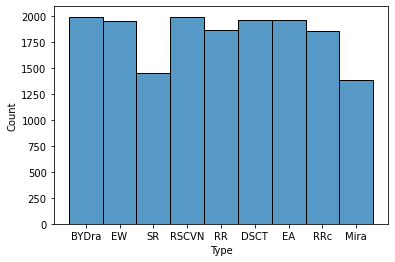

In [7]:
# Plot histogram of variable types in the dataset

sns.histplot(data=df, x=df.Type)

## Various functions to create multiple classifiers

In [8]:
def multiple_to_2labels(df,variable_type):
    """
    converts multiple labels for diffrent variable types to only two labels for one vs all classifier.
    Returns 2 data frames: 
    1. Original data frame with new labels. 
    2. Dataframe with equal candidates of the two classes.
    """
    OneClass = variable_type
    df0 = df.copy()
    df0.loc[df0.Type != OneClass,'Type'] = 'ZZ'
    df1 = df0[df0.Type == 'ZZ']
    df2 = df0[df0.Type == OneClass]

    df3 = df1.sample(n=6000, random_state=1) # balance data type by only selecting 1000 of other type
    frames = [df2,df3]
    df_balanced = pd.concat(frames)
    return df0, df_balanced

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def preprocess_data(df):
    """
    Preprocess data for one vs all classifier and split it to train/test data
    """
    # Map string labels to numbers
    label = df.Type

    le = preprocessing.LabelEncoder()
    le.fit(label)

    # Drop columns that are not features
    X = df
    # Encode labels to form y labels
    y = le.transform(df.Type)

    # Split dataset into training set and test set
    X_tr, X_ts, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
    X_train = X_tr.drop(['index','Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    X_test = X_ts.drop(['index','Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    return X_train, X_test, y_train, y_test
    

In [10]:

from sklearn import metrics
# from sklearn.metrics import confusion_matrix
def oneVSall_classiffier(name,model,X_train, X_test, y_train, y_test):
    """
    Train Classifier using train dataset. Calculate classifier metrics using test dataset
    """
    #Train the model using the training sets 
    if name == ("Isolation Forest" or "One Class SVM"):
        X_train = X_train[y_train==0]
        model.fit(X_train)
    else:
        model.fit(X_train,y_train)

    # Predict test data output
    y_pred = model.predict(X_test)
    
    # Estimate model performance on test data
    if name == "Isolation Forest" or "One Class SVM":
        one_index = np.where(y_pred==1)
        y_pred[one_index] = 1
        negone_index = np.where(y_pred==-1)
        y_pred[negone_index] = 0
    accuracy = metrics.accuracy_score(y_test, y_pred)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
                                      
    return model, accuracy, precision, recall, confusion

## Train and Compare Classifiers

In [11]:
# list of classification methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from sklearn.svm import OneClassSVM

# names = ["Isolation Forest", "One Class SVM", "XG Boost","Random Forest", "Decision Tree", "Logistic Regression", "Naive Bayes"]
clf_names = ["XG Boost","Random Forest", "Decision Tree", "Logistic Regression", "Naive Bayes"]

classifiers = [
#     IsolationForest(contamination=0.01),
#     OneClassSVM(gamma='scale', nu=0.01),
    XGBClassifier(use_label_encoder=False),
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier(criterion="gini", max_depth=3),
    LogisticRegression(solver = 'liblinear',max_iter = 500),
    GaussianNB()]
    


In [12]:
# Run loop to train all classifiers and collect metrics in a dataframe
accuracy ={}
precision = {}
recall = {}
confusion ={}
fitted_models={}

# create comparision dataframe
header = pd.MultiIndex.from_product([clf_names,
                                     ['acc.','preci.','recall']],
                                    names=['classifier','metric(avg)'])
index_label = label
pd_comparison = pd.DataFrame(data=None, index=index_label, columns=header, dtype=None, copy=False)
for name in clf_names:
    accuracy[name] = {}
    precision[name] = {}
    recall[name] = {}
    confusion[name] ={}
    fitted_models[name]={}

# train models and collect metrics on test data
for variable_type in label: #loop over different types of variable stars
    print(variable_type)
    for p in range(1,11): # train each classification 10 times for each variable type
        df0, df_balanced = multiple_to_2labels(df,variable_type)
        X_train, X_test, y_train, y_test = preprocess_data(df_balanced)
        for name, clf in zip(clf_names, classifiers): # loop over different classifiers
            print(name)
            clf, accuracy_int, precision_int,recall_int, confusion_int  = oneVSall_classiffier(name,clf,X_train, X_test, y_train, y_test)
            # calculate average accuracy, precision and recall
            if p == 1:
                accuracy[name][variable_type] = 0
                precision[name][variable_type] = 0
                recall[name][variable_type] = 0
            accuracy[name][variable_type] = accuracy_int/p + accuracy[name][variable_type]*(p-1)/p
            precision[name][variable_type] = precision_int/p + precision[name][variable_type]*(p-1)/p
            recall[name][variable_type] =recall_int/p + recall[name][variable_type]*(p-1)/p
            
            confusion[name][variable_type] = confusion_int # save confusion only of the 10th iteration
            fitted_models[name][variable_type] = pickle.dumps(clf) # save model only of the 10th iteration
for name in clf_names:        
    pd_comparison.loc[:,(name,'acc.')] = list(accuracy[name].values())
    pd_comparison.loc[:,(name,'preci.')] = list(precision[name].values())
    pd_comparison.loc[:,(name,'recall')] = list(recall[name].values())
    


BYDra
XG Boost
[12:51:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Random Forest
Decision Tree
Logistic Regression
Naive Bayes
EW
XG Boost
[12:51:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Random Forest
Decision Tree
Logistic Regression
Naive Bayes
SR
XG Boost
[12:51:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behav

In [13]:
# print the comparision table
pd_comparison_rounded = pd_comparison.round(decimals=2)
pd_comparison_rounded.head(20)

classifier  XG Boost               Random Forest               Decision Tree  \
metric(avg)     acc. preci. recall          acc. preci. recall          acc.   
BYDra           0.85   0.90   0.89          0.85   0.91   0.90          0.81   
EW              0.92   0.93   0.97          0.92   0.92   0.97          0.85   
SR              0.94   0.94   0.99          0.93   0.93   0.99          0.87   
RSCVN           0.81   0.86   0.89          0.82   0.86   0.92          0.78   
RR              0.96   0.97   0.98          0.96   0.96   0.98          0.92   
DSCT            0.91   0.93   0.95          0.89   0.90   0.95          0.80   
EA              0.97   0.98   0.98          0.97   0.98   0.98          0.96   
RRc             0.94   0.95   0.97          0.94   0.95   0.98          0.89   
Mira            1.00   1.00   1.00          1.00   1.00   1.00          1.00   

classifier                Logistic Regression               Naive Bayes  \
metric(avg) preci. recall                acc. preci. recall        acc.   
BYDra         0.89   0.85                0.82   0.88   0.89        0.55   
EW            0.90   0.90                0.84   0.84   0.96        0.38   
SR            0.89   0.95                0.93   0.93   0.99        0.32   
RSCVN         0.79   0.96                0.77   0.82   0.89        0.54   
RR            0.91   0.99                0.93   0.95   0.96        0.79   
DSCT          0.86   0.88                0.82   0.84   0.93        0.49   
EA            0.97   0.98                0.96   0.97   0.98        0.48   
RRc           0.92   0.95                0.91   0.94   0.94        0.72   
Mira          1.00   1.00                1.00   1.00   1.00        0.98   

classifier                 
metric(avg) preci. recall  
BYDra         0.98   0.42  
EW            0.96   0.19  
SR            0.90   0.19  
RSCVN         0.97   0.40  
RR            0.99   0.74  
DSCT          0.96   0.32  
EA            0.98   0.32  
RRc           0.99   0.64  
Mira          1.00   0.98

In [14]:
pd_comparison.to_csv('comparison_unbalanced.csv')

In [15]:
def preprocess_data2(df):
    """
    Preprocess data for one vs all classifier.
    Return the features dataframe and labels
    """
    # Map string labels to numbers
    label = df.Type

    le = preprocessing.LabelEncoder()
    le.fit(label)

    # Drop columns that are not features
    X = df.drop(['index','Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    # Encode labels to form y labels
    y = le.transform(df.Type)
    return X, y

In [16]:
def find_probabilities(fitted_models,df,variable_type):
    """
    Push all the data through a 1 vs all classfier. 
    Return the classification probabilities in the two clsses
    """
    df0,df_oneVsAll = multiple_to_2labels(df,variable_type)
    X, y = preprocess_data2(df0)
    clf_XGBoost =  pickle.loads(fitted_models['XG Boost'][variable_type])
    clf_XGBoost =  pickle.loads(fitted_models['XG Boost'][variable_type])
#     print(clf_XGBoost.feature_importances_)
    y_prob = clf_XGBoost.predict_proba(X)
    return y_prob

In [17]:
# iterate over 1 vs all XG Boost classifiers for all varaibles and find probabilities
all_probs={}
for variable_type in label:
#     print(variable_type)
    all_probs[variable_type] = find_probabilities(fitted_models,df,variable_type)

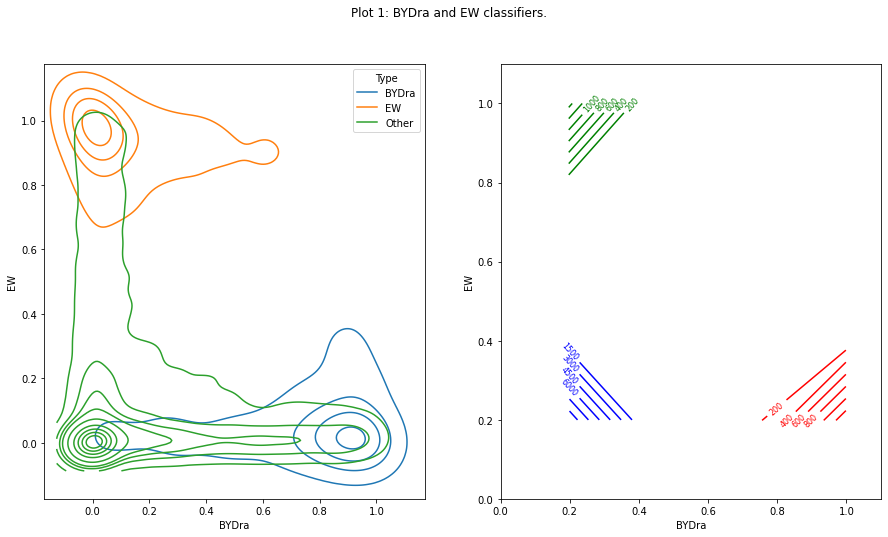

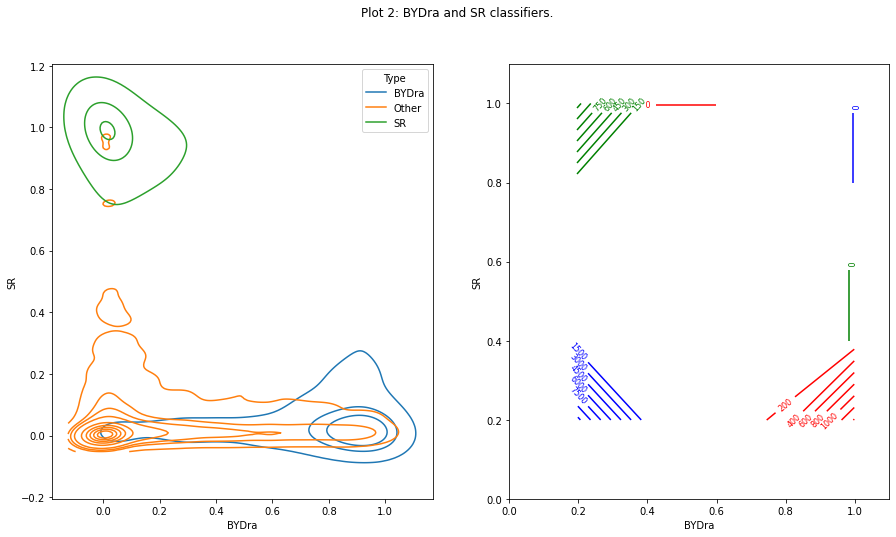

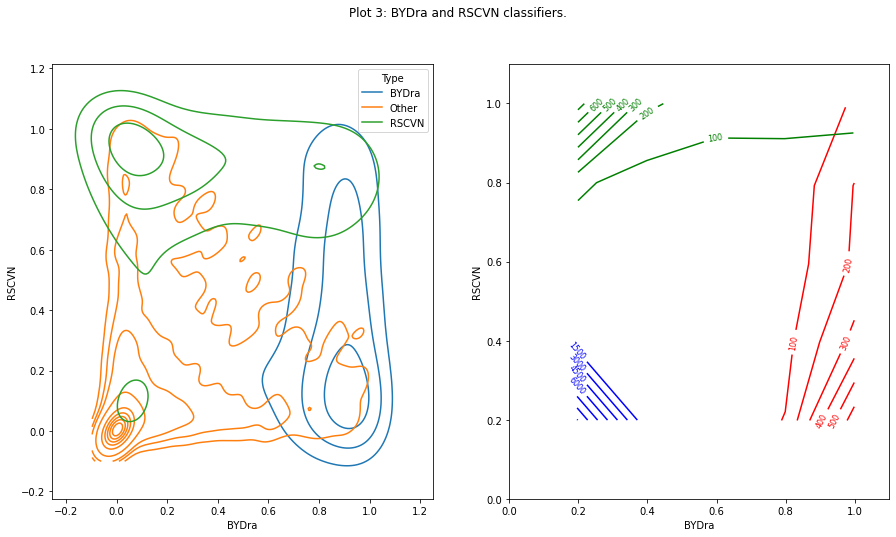

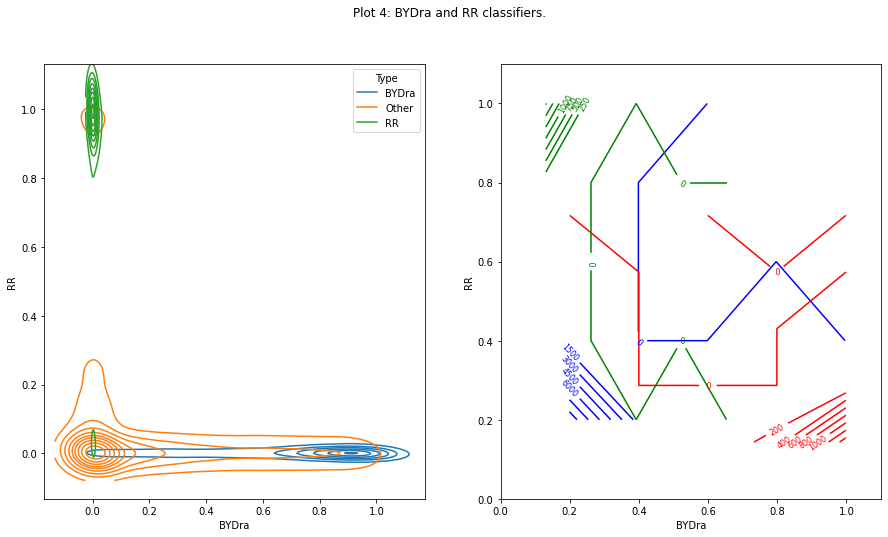

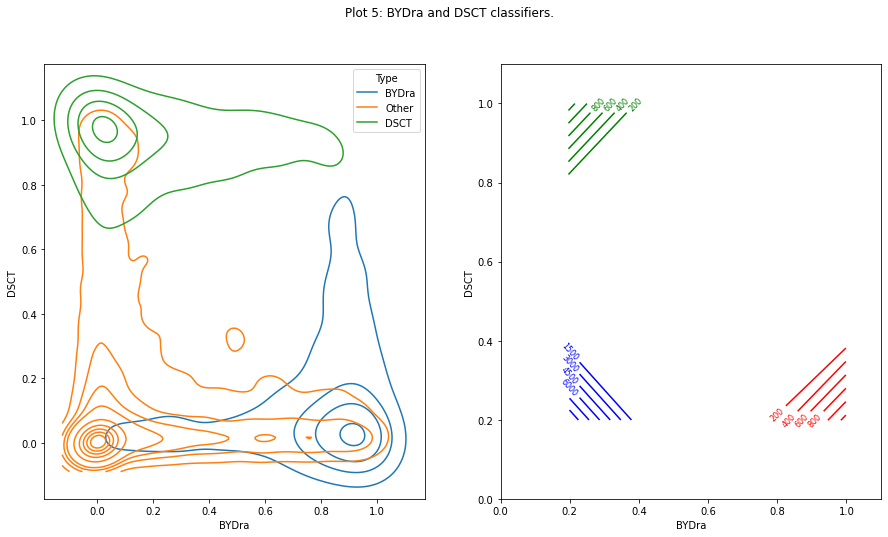

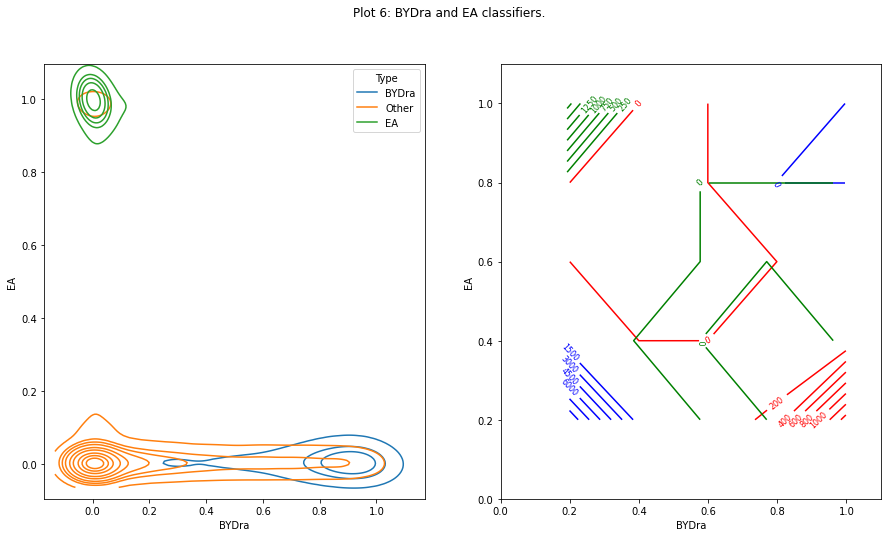

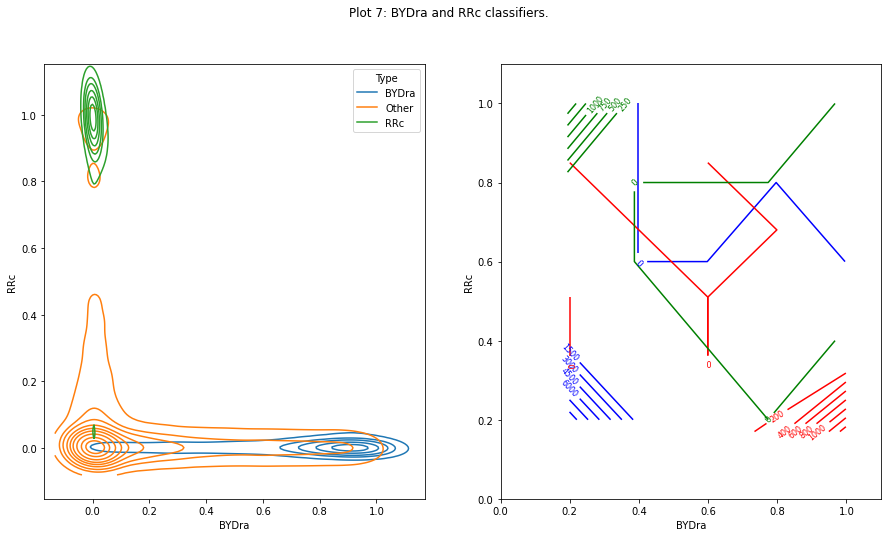

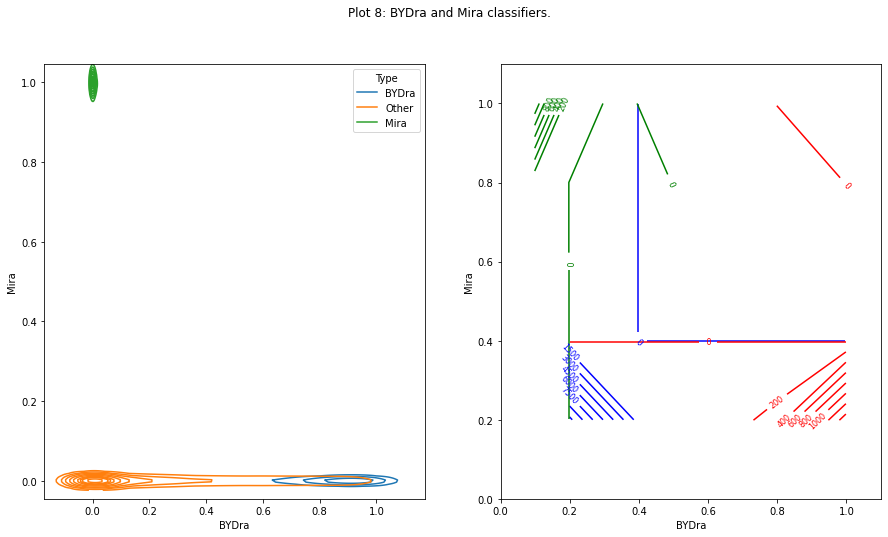

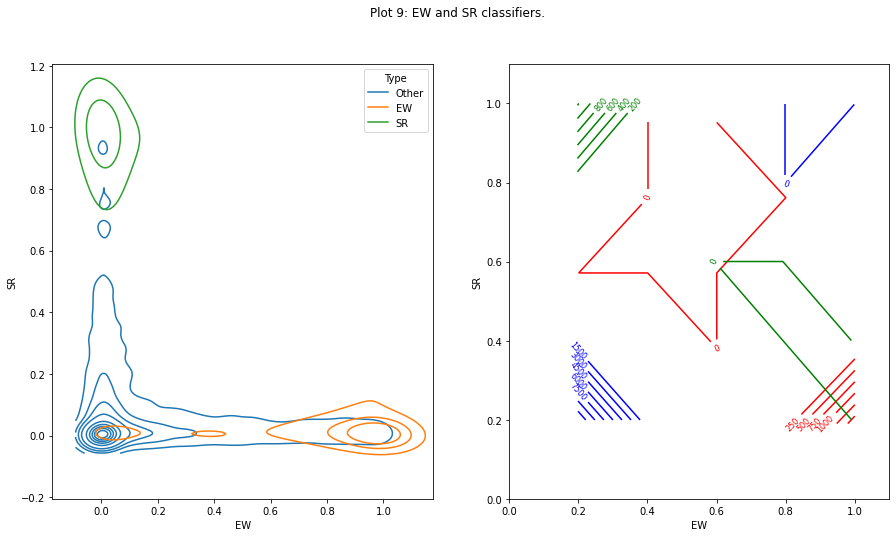

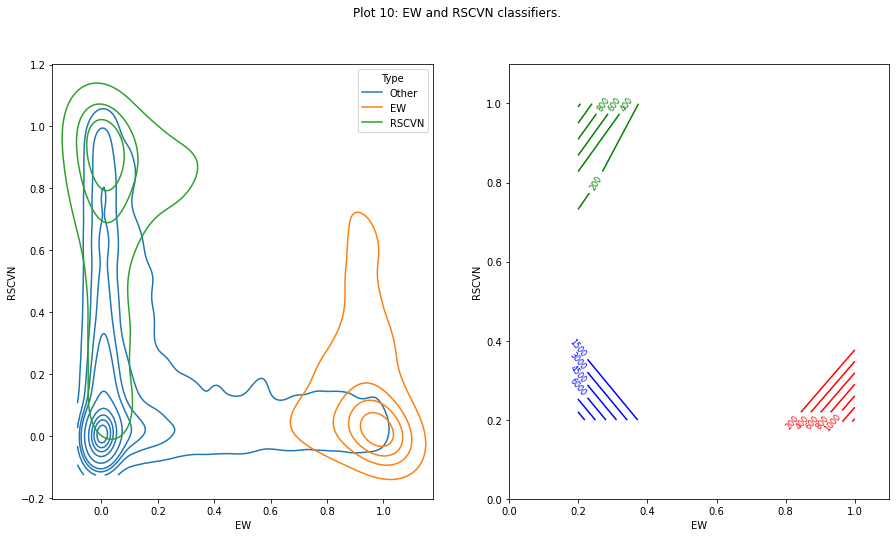

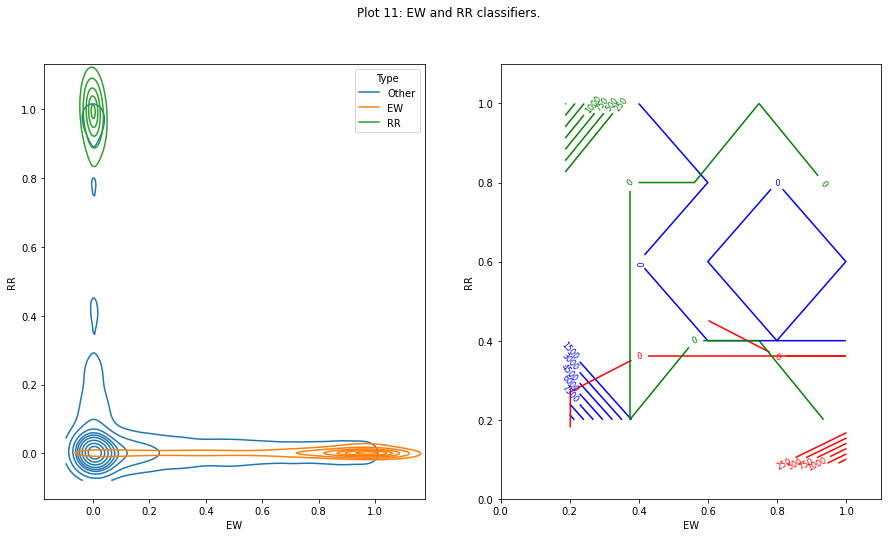

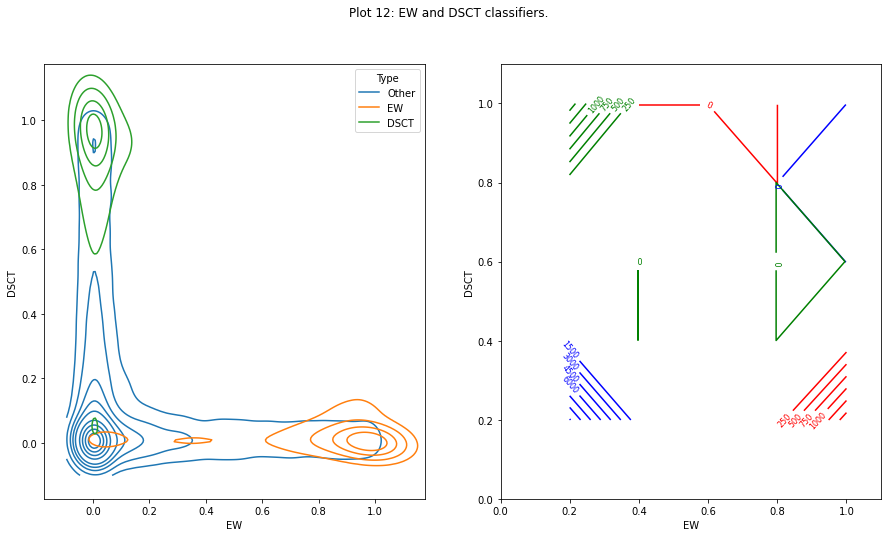

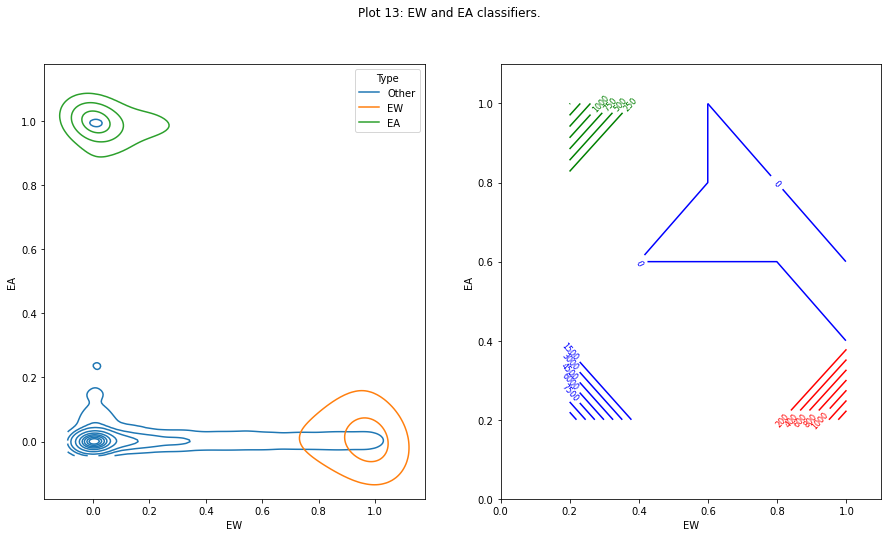

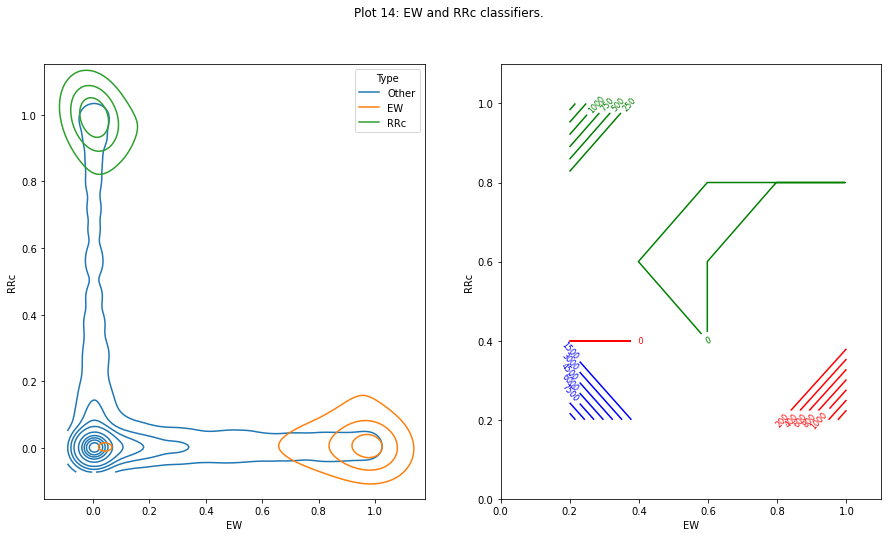

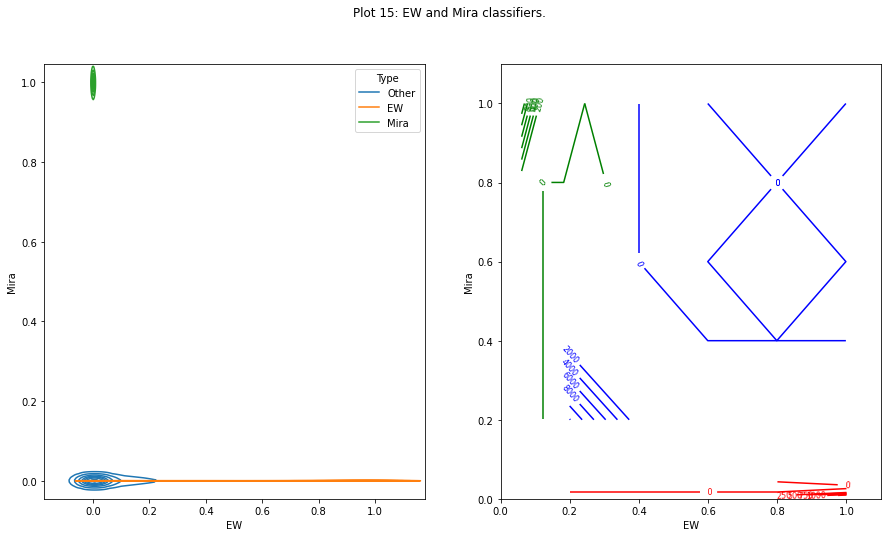

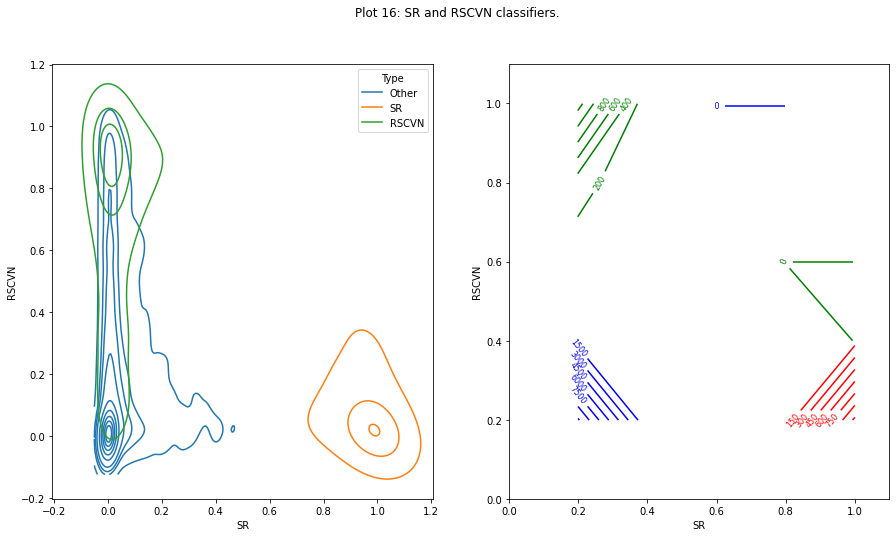

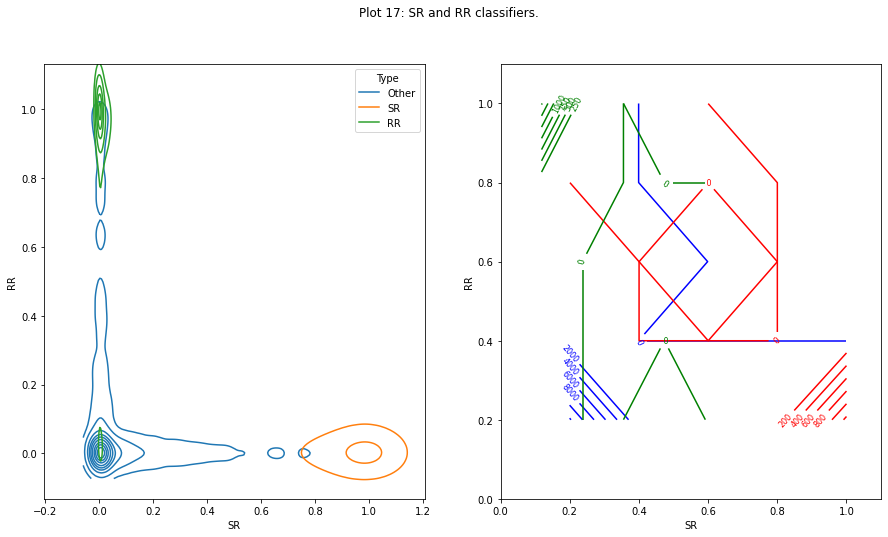

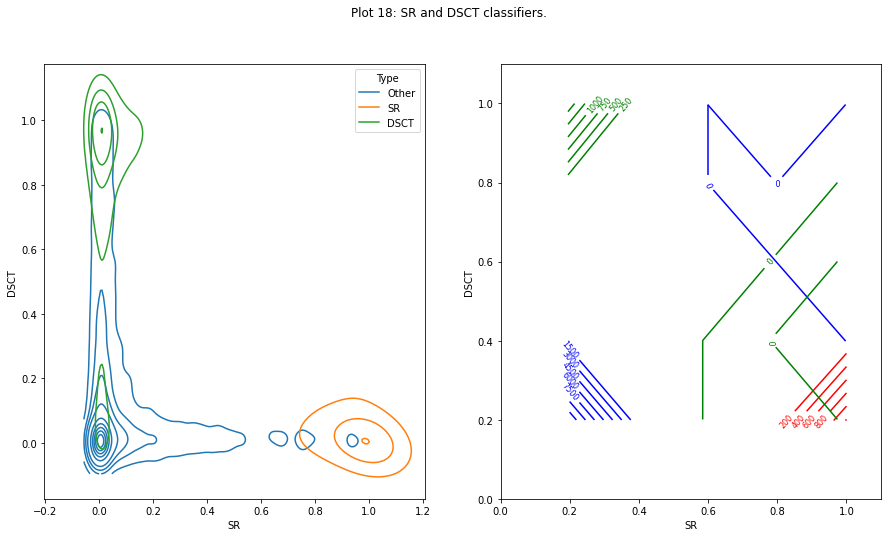

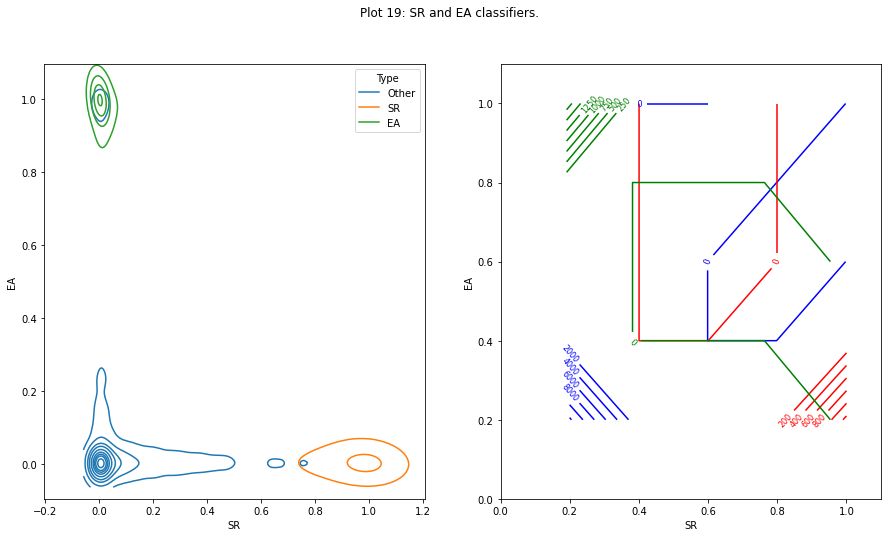

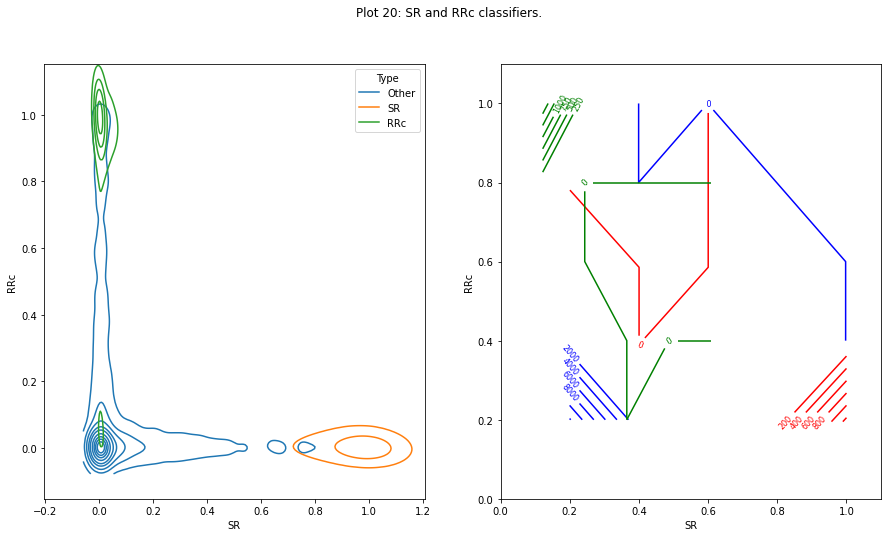

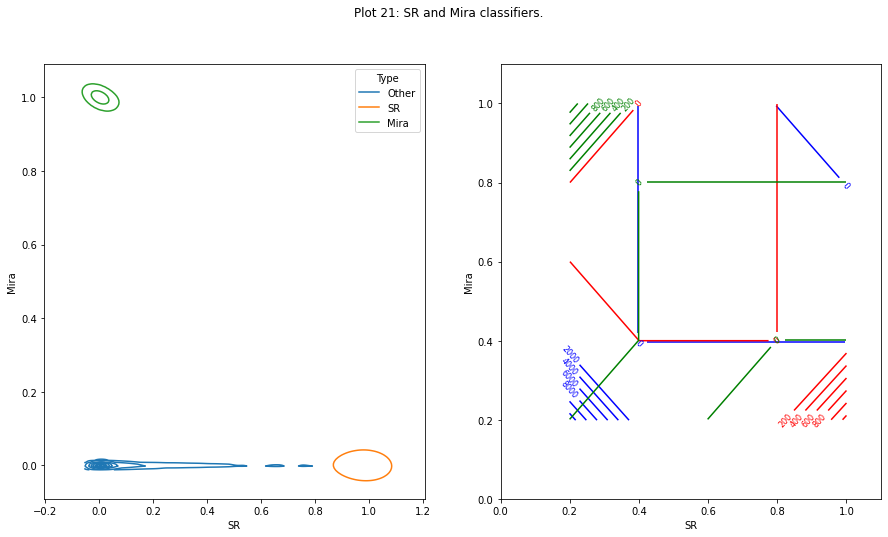

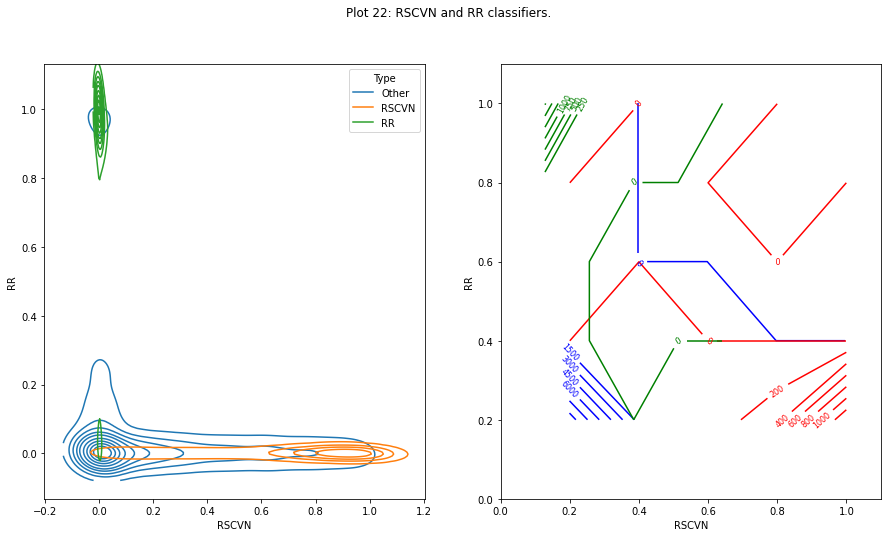

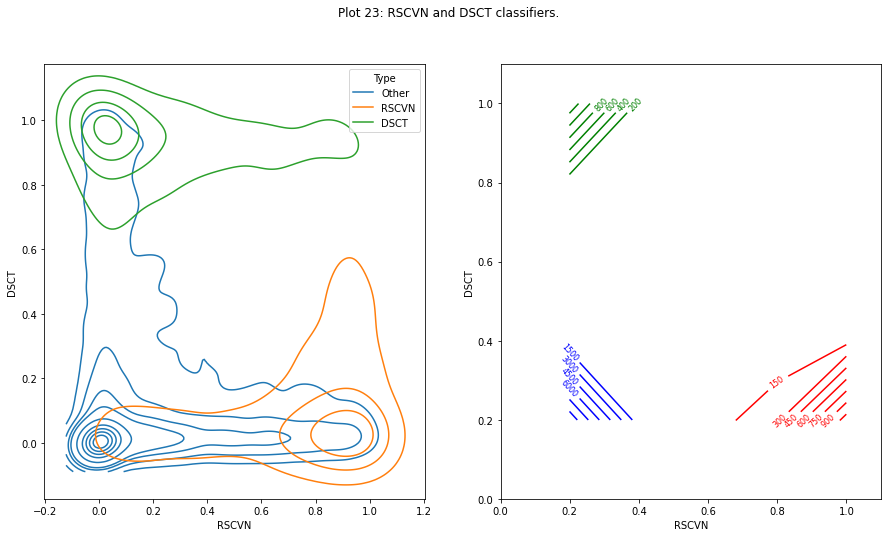

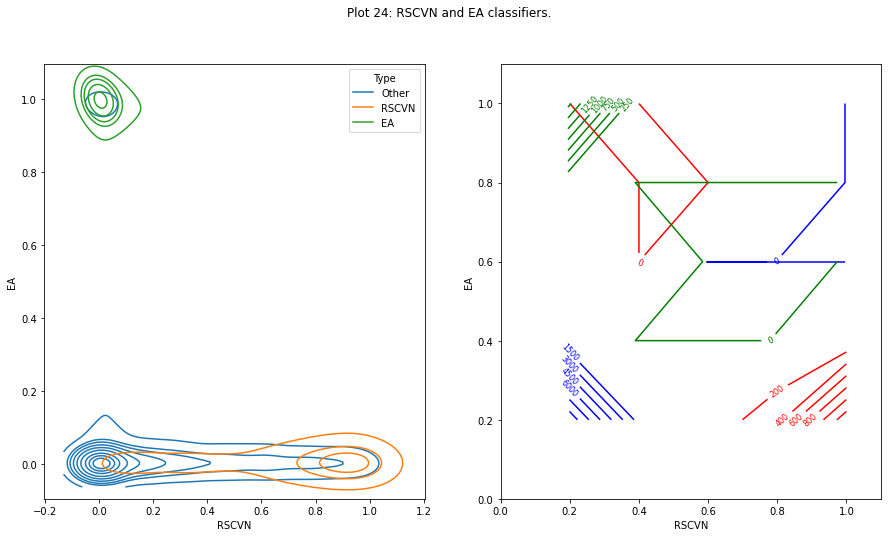

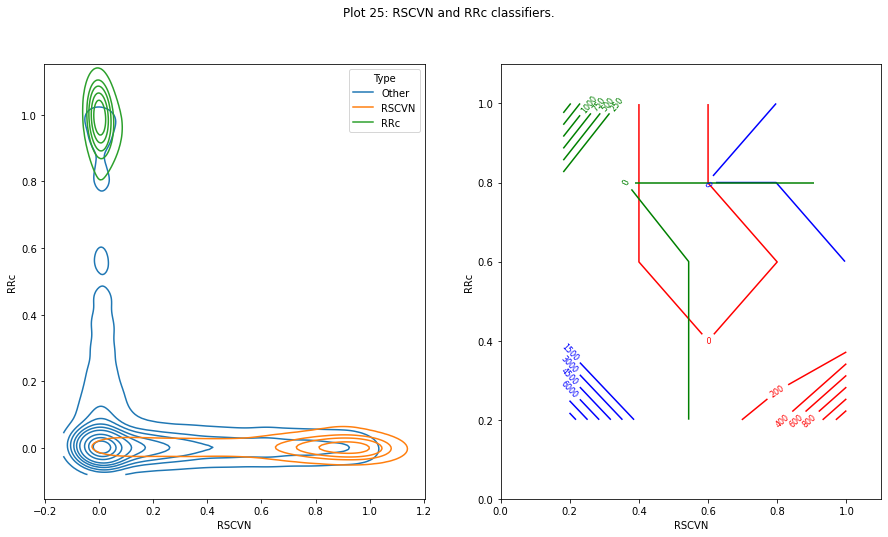

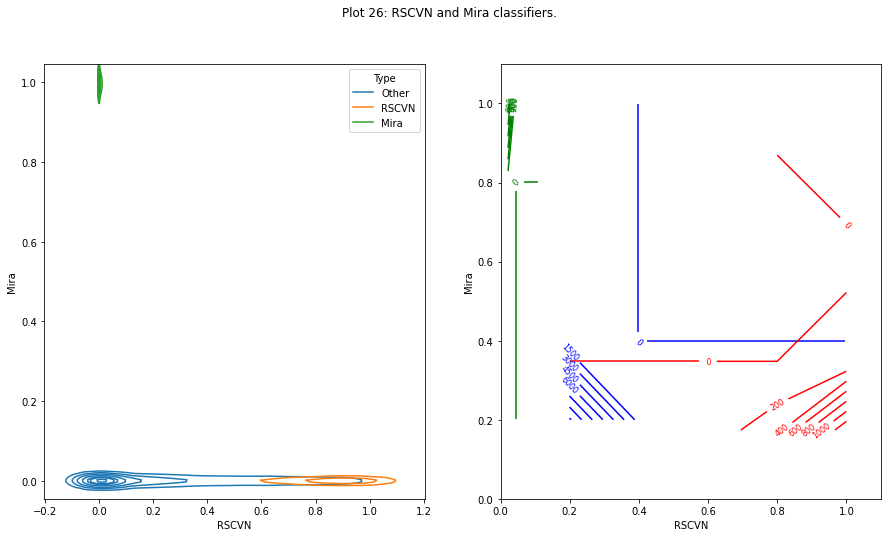

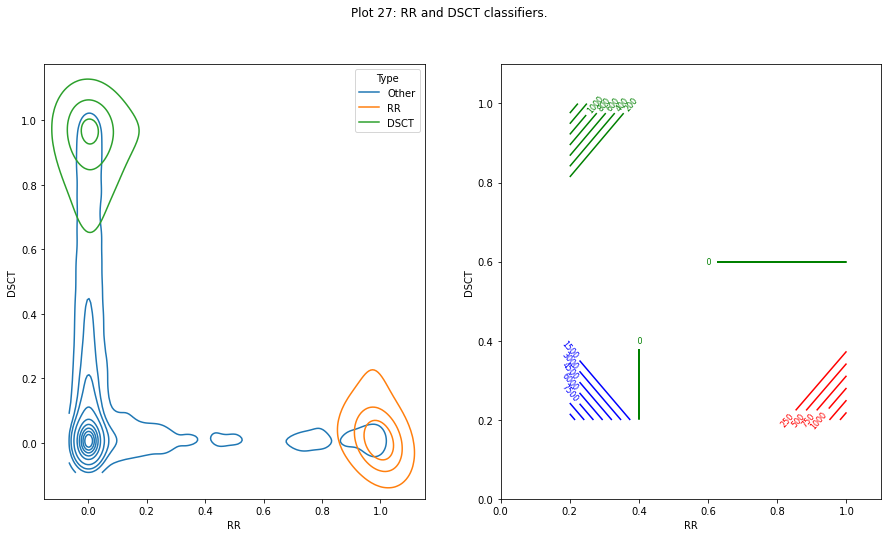

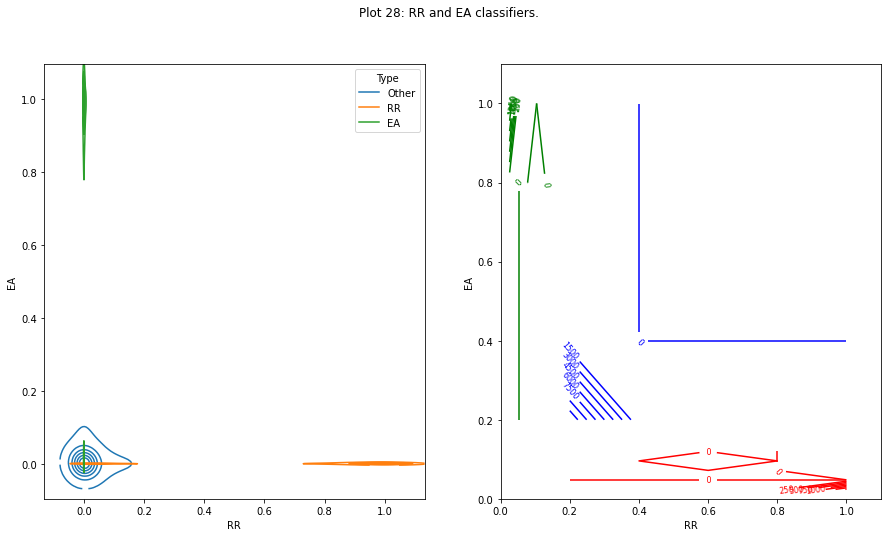

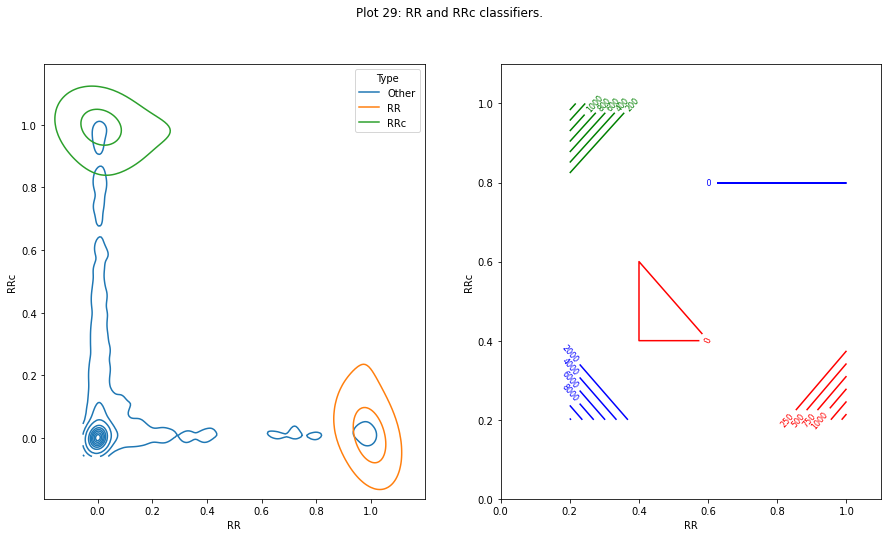

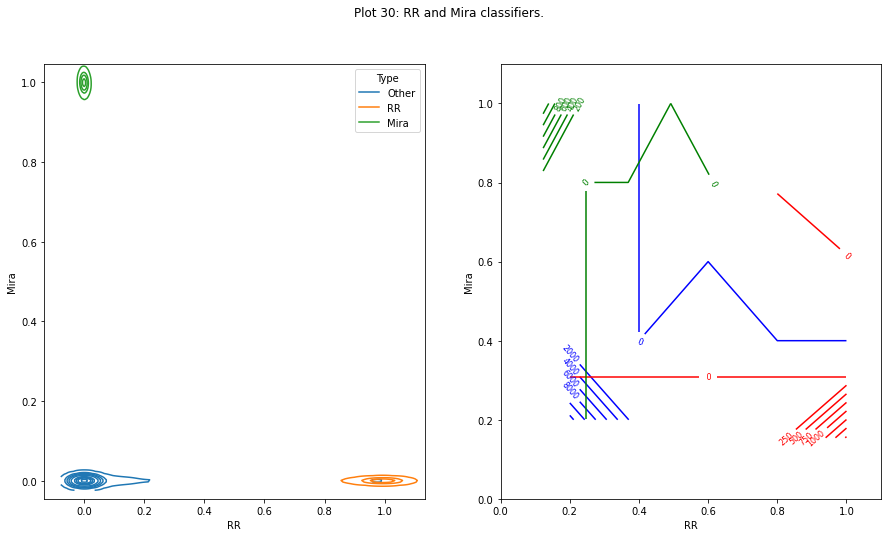

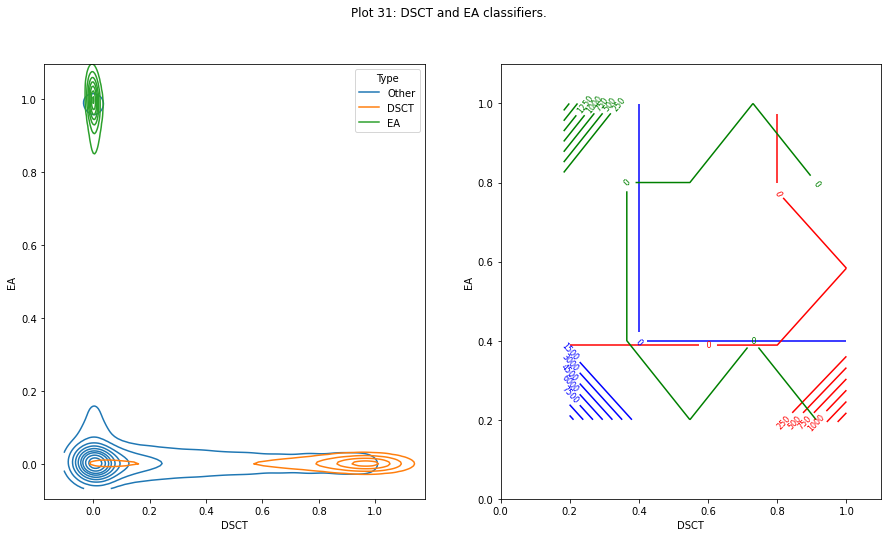

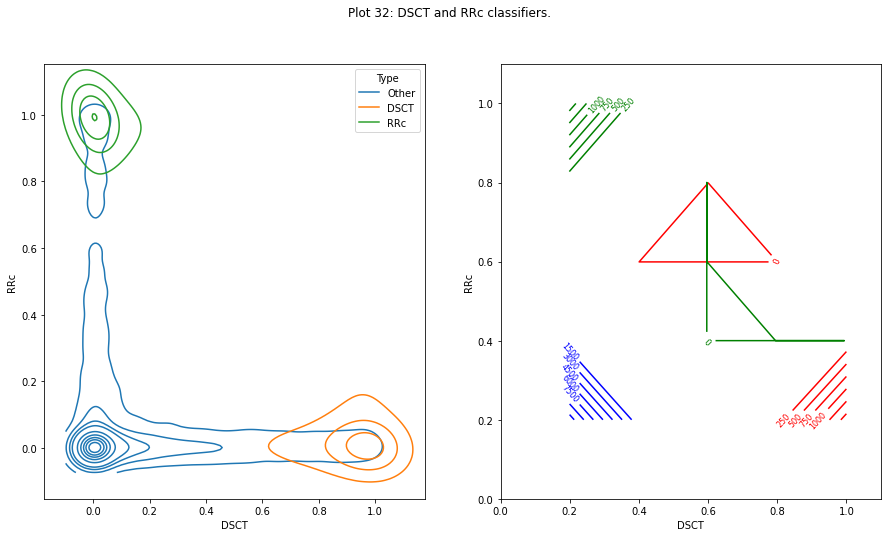

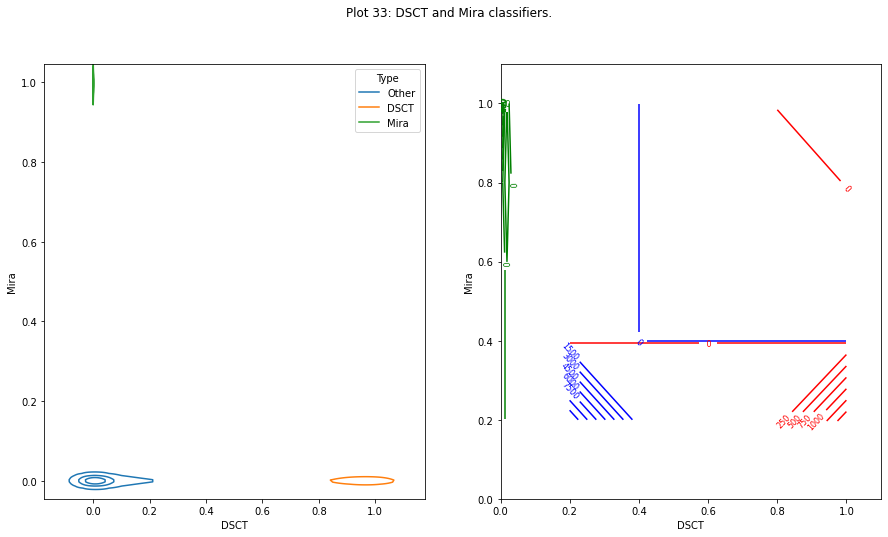

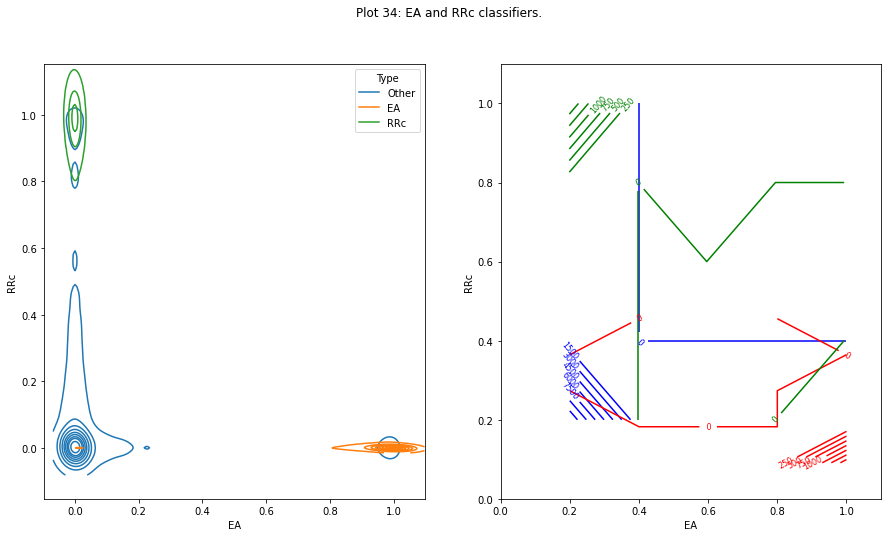

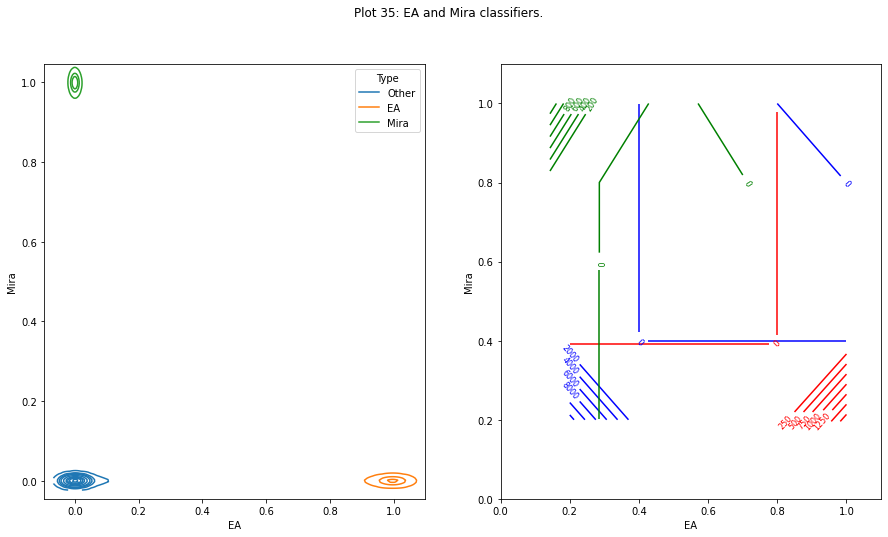

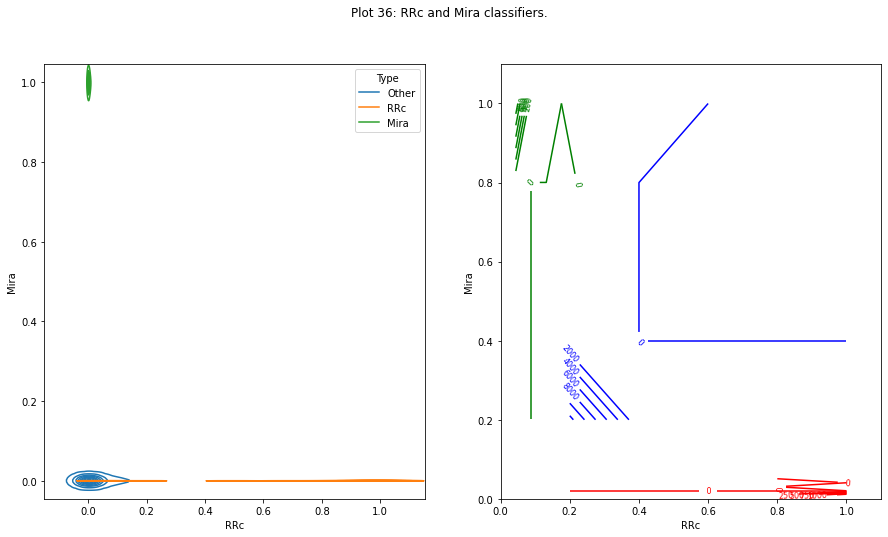

In [18]:
# plot the probabilities from 2 classifiers at a time

n = len(label)
j = 0
for i in range(0,n):
    for k in range(i+1,n):
        j = j+1
        variable_type1 = label[i]
        variable_type2 = label[k]
        df_prob = pd.DataFrame(columns=[variable_type1, variable_type2, 'Type'])
        prob1 = all_probs[variable_type1][:,0]
        prob2 = all_probs[variable_type2][:,0]
        df_prob[variable_type1] = prob1
        df_prob[variable_type2] = prob2
        ind1 = df.index[df['Type']==variable_type1].values
        ind2 = df.index[df['Type']==variable_type2].values
        ind3 = df.index[(df['Type'] != variable_type1) & (df['Type'] != variable_type2)]
        
        
        df_prob.loc[ind1,'Type'] = variable_type1
        df_prob.loc[ind2,'Type'] = variable_type2
        df_prob.loc[ind3,'Type'] = 'Other' 
        
        title_string = "Plot {}: {} and {} classifiers.".format(j,variable_type1, variable_type2)
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,8))
        sns.kdeplot(data = df_prob,x=variable_type1,y=variable_type2, ax=ax1, hue='Type')
        
        
        H, xedges, yedges = np.histogram2d(prob1[ind3],prob2[ind3], bins=(5,5))
        contours=ax2.contour(xedges[1:],yedges[1:],H.T, colors='blue')
        ax2.set_xlim([0,1.1])
        ax2.set_ylim([0,1.1])
        ax2.clabel(contours,fmt = '%2.1d', inline=True, fontsize=8)
        
        
        H, xedges, yedges = np.histogram2d(prob1[ind1],prob2[ind1], bins=(5,5))
        contours=ax2.contour(xedges[1:],yedges[1:],H.T, colors='red')
        ax2.clabel(contours, fmt = '%2.1d', inline=True, fontsize=8)
        
        H, xedges, yedges = np.histogram2d(prob1[ind2],prob2[ind2], bins=(5,5))
        contours=ax2.contour(xedges[1:],yedges[1:],H.T, colors='green')
        ax2.clabel(contours, fmt = '%2.1d', inline=True, fontsize=8)
        
        plt.xlabel(variable_type1)
        plt.ylabel(variable_type2)
        title_string = "Plot {}: {} and {} classifiers.".format(j,variable_type1, variable_type2)
        fig.suptitle(title_string)

        plt.show()
        del ind1, ind2, ind3, df_prob

        

## Scaled Feature importance for each one vs all classifier

In [19]:
# create tabe of feature importance
pd_feature = pd.DataFrame(columns=label,index=X_train.columns.values)
for variable_type in label:
    clf_XGBoost =  pickle.loads(fitted_models['XG Boost'][variable_type])
    pd_feature[variable_type] = clf_XGBoost.feature_importances_/max(clf_XGBoost.feature_importances_)

In [20]:
# A simple categorical heatmap
# code from : https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

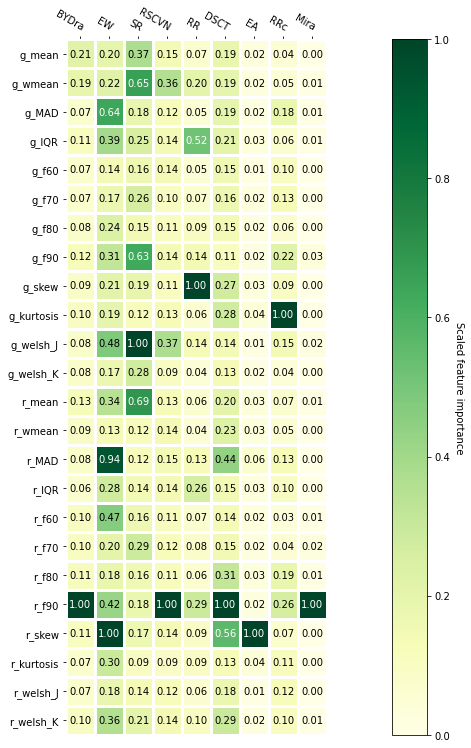

In [21]:
feature_imp = pd_feature.to_numpy()
xlabel = pd_feature.columns.values
ylabel = pd_feature.index.values
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
im, cbar = heatmap(feature_imp, ylabel, xlabel, ax=ax,
                   cmap="YlGn", cbarlabel="Scaled feature importance")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

In [22]:
# feature importance in table format
pd_feature.head(25)

,BYDra,EW,SR,RSCVN,RR,DSCT,EA,RRc,Mira
g_mean,0.211588,0.196976,0.372313,0.145584,0.066932,0.187205,0.019981,0.043067,0.002859
g_wmean,0.190706,0.219307,0.654836,0.360024,0.199956,0.191508,0.020291,0.048548,0.005892
g_MAD,0.067730,0.639217,0.182602,0.120216,0.048705,0.192972,0.015042,0.176169,0.005067
g_IQR,0.109201,0.390769,0.253817,0.143759,0.518293,0.206149,0.027298,0.063159,0.008065
g_f60,0.071168,0.140898,0.163518,0.139186,0.046990,0.154153,0.014425,0.104904,0.000616
g_f70,0.073220,0.169437,0.260587,0.102633,0.068732,0.159072,0.020320,0.128561,0.003143
g_f80,0.081223,0.240013,0.150637,0.107247,0.094587,0.145201,0.018631,0.056844,0.001481
g_f90,0.124743,0.312966,0.625039,0.142600,0.143084,0.107162,0.017021,0.215488,0.028031
g_skew,0.088546,0.209201,0.187612,0.106541,1.000000,0.269827,0.025492,0.094990,0.003006
g_kurtosis,0.096500,0.192951,0.118321,0.126585,0.060974,0.276087,0.037144,1.000000,0.000786


In [23]:
n_estimators = []
max_depth = []
learning_rate = []
colsample_bytree =[]
gamma =[]
subsample = []
for variable_type in label:
    clf = fitted_models['XG Boost'][variable_type]
    params = clf_XGBoost.get_params()
    n_estimators.append(params['n_estimators'])
    max_depth.append(params['max_depth'])
    learning_rate.append(params['learning_rate'])
    colsample_bytree.append(params['colsample_bytree'])
    gamma.append(params['gamma'])
    subsample.append(params['subsample'])
pd_XGB_optimized = pd.DataFrame(index=label,columns=['n_estimators','max_depth','learning_rate','colsample_bytree','gamma','subsample'])
pd_XGB_optimized['n_estimators'] =n_estimators
pd_XGB_optimized['max_depth'] = max_depth
pd_XGB_optimized['learning_rate'] = learning_rate
pd_XGB_optimized['colsample_bytree'] = colsample_bytree
pd_XGB_optimized['gamma'] = gamma
pd_XGB_optimized['subsample'] = subsample

In [24]:
pd_XGB_optimized.head(10)

,n_estimators,max_depth,learning_rate,colsample_bytree,gamma,subsample
BYDra,100,6,0.3,1,0,1
EW,100,6,0.3,1,0,1
SR,100,6,0.3,1,0,1
RSCVN,100,6,0.3,1,0,1
RR,100,6,0.3,1,0,1
DSCT,100,6,0.3,1,0,1
EA,100,6,0.3,1,0,1
RRc,100,6,0.3,1,0,1
Mira,100,6,0.3,1,0,1


## Notes:
1. Each classifiers was trained on ~2000 balanced datapoints from a total data ~9000 points.
1. Each one vs all classifier had high accuracy, precision and recall (>80% or 90% in most cases) for XG Boost classifier
1. But when we compare how one classifier classifies data from other class using all 9000 data points there are plenty of mis-classification. More than 20% data which is mis-classfied if we consider a probability threshold of 0.5.
1. To improve classification we need to 
    1. Tune the model
    1. Add more features especially pertaining to period calculation
    1. Use more data
1. Preliminary exploration shows Tuning or adding more data doesnot give a big boost to increasing classification accuarcy. Add better features might help.

In [28]:
# Run loop to train all optimized XGB classifier 10 times and collect average metrics in a dataframe
accuracy ={}
precision = {}
recall = {}
confusion ={}


# create comparision dataframe
header = pd.MultiIndex.from_product([clf_names,
                                     ['acc.','preci.','recall']],
                                    names=['classifier','metric(avg)'])
index_label = label
pd_comparison = pd.DataFrame(data=None, index=index_label, columns=header, dtype=None, copy=False)

# train models and collect metrics on test data
for variable_type in label: #loop over different types of variable stars
    print(variable_type)
    for p in range(1,11): # train each classification 10 times for each variable type
        df0, df_balanced = multiple_to_2labels(df,variable_type)
        X_train, X_test, y_train, y_test = preprocess_data(df_balanced)
        """
        Train Classifier using train dataset. Calculate classifier metrics using test dataset
        """
        #Train the model using the training sets
        model = pickle.loads(fitted_models['XG Boost'][variable_type])
        model.fit(X_train,y_train)

        # Predict test data output
        y_pred = model.predict(X_test)

        accuracy_int = metrics.accuracy_score(y_test, y_pred)
        confusion_int = metrics.confusion_matrix(y_test, y_pred)
        precision_int = metrics.precision_score(y_test, y_pred)
        recall_int = metrics.recall_score(y_test, y_pred)
        
        # calculate average accuracy, precision and recall
        if p == 1:
            accuracy[variable_type] = 0
            precision[variable_type] = 0
            recall[variable_type] = 0
        accuracy[variable_type] = accuracy_int/p + accuracy[variable_type]*(p-1)/p
        precision[variable_type] = precision_int/p + precision[variable_type]*(p-1)/p
        recall[variable_type] = recall_int/p + recall[variable_type]*(p-1)/p
            
        confusion[variable_type] = confusion_int # save confusion only of the 10th iteration


BYDra
[13:09:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:09:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:09:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:09:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

RSCVN
[13:09:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:09:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:09:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:09:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

EA
[13:10:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:10:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:10:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:10:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

In [32]:
pd_comparison.loc[:,('XB Boost','acc.')] = list(accuracy['XG Boost'].values())
pd_comparison.loc[:,('XB Boost','preci.')] = list(precision['XG Boost'].values())
pd_comparison.loc[:,('XB Boost','recall')] = list(recall['XG Boost'].values())

KeyError: 'XG Boost'

In [33]:
pd_comparison.head(10)

classifier  XG Boost               Random Forest               Decision Tree  \
metric(avg)     acc. preci. recall          acc. preci. recall          acc.   
BYDra            NaN    NaN    NaN           NaN    NaN    NaN           NaN   
EW               NaN    NaN    NaN           NaN    NaN    NaN           NaN   
SR               NaN    NaN    NaN           NaN    NaN    NaN           NaN   
RSCVN            NaN    NaN    NaN           NaN    NaN    NaN           NaN   
RR               NaN    NaN    NaN           NaN    NaN    NaN           NaN   
DSCT             NaN    NaN    NaN           NaN    NaN    NaN           NaN   
EA               NaN    NaN    NaN           NaN    NaN    NaN           NaN   
RRc              NaN    NaN    NaN           NaN    NaN    NaN           NaN   
Mira             NaN    NaN    NaN           NaN    NaN    NaN           NaN   

classifier                Logistic Regression               Naive Bayes  \
metric(avg) preci. recall                acc. preci. recall        acc.   
BYDra          NaN    NaN                 NaN    NaN    NaN         NaN   
EW             NaN    NaN                 NaN    NaN    NaN         NaN   
SR             NaN    NaN                 NaN    NaN    NaN         NaN   
RSCVN          NaN    NaN                 NaN    NaN    NaN         NaN   
RR             NaN    NaN                 NaN    NaN    NaN         NaN   
DSCT           NaN    NaN                 NaN    NaN    NaN         NaN   
EA             NaN    NaN                 NaN    NaN    NaN         NaN   
RRc            NaN    NaN                 NaN    NaN    NaN         NaN   
Mira           NaN    NaN                 NaN    NaN    NaN         NaN   

classifier                XB Boost                
metric(avg) preci. recall     acc. preci. recall  
BYDra          NaN    NaN    BYDra  BYDra  BYDra  
EW             NaN    NaN       EW     EW     EW  
SR             NaN    NaN       SR     SR     SR  
RSCVN          NaN    NaN    RSCVN  RSCVN  RSCVN  
RR             NaN    NaN       RR     RR     RR  
DSCT           NaN    NaN     DSCT   DSCT   DSCT  
EA             NaN    NaN       EA     EA     EA  
RRc            NaN    NaN      RRc    RRc    RRc  
Mira           NaN    NaN     Mira   Mira   Mira